In [1]:
import pandas as pd
import numpy as np
import random
import math
import gc
import matplotlib.pyplot as plt
import networkx
from copy import deepcopy
from collections import defaultdict
import marshal
import sys

In [2]:
num_vertices = 100

In [3]:
def make_graph_matrices(num_vertices):
    edges = []
    vertices = list(range(num_vertices))
    # Initialize adjacency matrix
    def init_adjacency_matrix(nodes, edges):
        adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)
        edge_probability = 0.085
        edges_cnt = 0
        for i in range(nodes):
            for j in range(i):
                prob = random.random()
                if prob < edge_probability:
                    adjacency_matrix[i,j] = 1
                    edges.append((i,j))
                    edges_cnt += 1
        return adjacency_matrix, edges
    adjacency_matrix, edges = init_adjacency_matrix(num_vertices, edges)
    G=networkx.Graph()
    G.add_nodes_from(list(range(num_vertices)))
    G.add_edges_from(edges)
    adjacency_list = networkx.to_dict_of_lists(G)
    return adjacency_list,adjacency_matrix, edges, G

In [4]:
ADJACENCY_LIST, ADJACENCY_MATRIX, EDGES, G = make_graph_matrices(num_vertices)

C:\Users\shriv\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


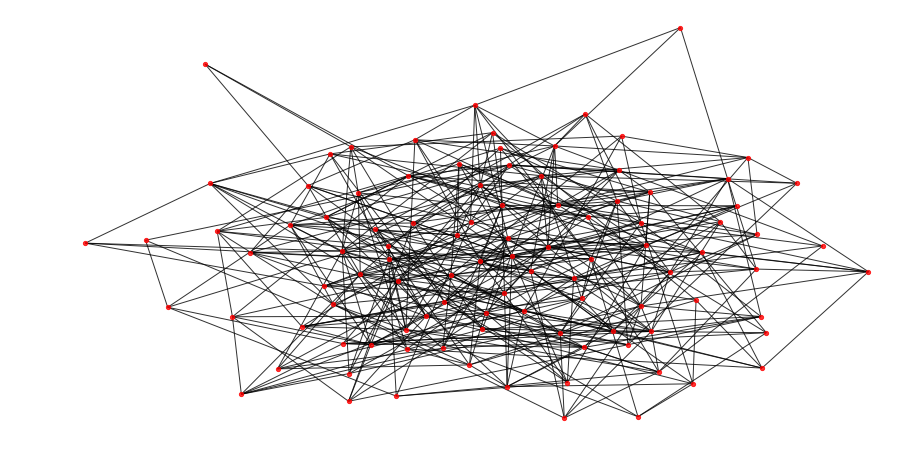

In [5]:
plt.figure(figsize=(12,6))
networkx.draw(G,node_color='r', node_size=18, alpha=0.8)
plt.show() # display

In [6]:
VERTEX_WEIGHTS = {node:1 for node in range(num_vertices)}

# Greedy Algorithm


In [7]:
#Vertex Cover Greedy Algorithm
visited = np.zeros(num_vertices)
greedy_vertex_dict = {}
greedy_edges = deepcopy(EDGES)
adjacency_matrix= deepcopy(ADJACENCY_MATRIX)
vertex_weights = deepcopy(VERTEX_WEIGHTS)
for vertex in range(num_vertices):
    greedy_vertex_dict[vertex] = sum(adjacency_matrix[vertex])/vertex_weights[vertex]

greedy_vertex_dict_ordered = dict(sorted(greedy_vertex_dict.items(), key=lambda item: item[1], reverse=True))

greedy_count = 0
vcount = 0
for vertex in greedy_vertex_dict_ordered:
    to_remove = set()
    for edge in greedy_edges:
        if vertex in edge:
            to_remove.add(edge)
    for edge in to_remove:
        greedy_edges.remove(edge)
    greedy_count +=vertex_weights[vertex]
    vcount += 1
    if len(greedy_edges) == 0: 
        break

In [8]:
print("Vertex cover weight is {}".format(greedy_count))

Vertex cover weight is 87


# Genetic Algorithms Unweighted

In [9]:
# Init
n = num_vertices
total_population = 15 #Maximum population allowed in environment
population_init = 10
max_iterations = 50
edges = deepcopy(EDGES)
cross_over_prob = 0.50
mutation_prob = 0.05

In [10]:
def chromosomes_generation(n,k,population_init):
    """n: int -> total vertices,
    k: int -> number of vertices in our solution vertex cover,
    popoulation_init: int -> initial population
    
    Description: Randomly initialize population with k vertices as our vertex cover 

    Args:
        n (int): total vertices
        k (int): number of vertices in our solution vertex cover
        population_init (int): initial_population

    Returns:
        List[List[int]]: vertex cover with k vertices
    """
    vertex_cover = []
    for i in range(population_init):
        chromosome = np.zeros(n,dtype=int)
        samples = random.sample(range(n),k=k)
        
        for j in range(k):
            chromosome[samples[j]] = 1
        vertex_cover.append(chromosome)
    return vertex_cover

# print(chromosomes_generation(n,3,population_init))

In [11]:
def cost(soln,edges):
    """
    Description: We use this to measure fitness. Given our vertex cover, we measure how many edges are missed.

    Args:
        soln (List[int]): list of k vertices
        edges (List[Tuple[int]]): list of edges

    Returns:
        int: number of missed edges
    """
    count = 0
    for e in edges:
        (u,v) = e
        if soln[u] == 0 and soln[v] == 0:
            count+=1
    return count

In [12]:
def selection_fittest(vertex_cover,total_population,edges):
    """
    Description: selection basis to pass solutions to next generation.
    This function just selects top performing solutions and passes them on to the next generation

    Args:
        vertex_cover (List[int]): list of k vertices
        total_population (int): total population
        edges (List[Tuple[int]]): list of edges
    """
    score = []
    output_lst = []
    len_vertex_cover = len(vertex_cover)
    
    for i in range(len_vertex_cover):
        score.append(cost(vertex_cover[i],edges))
    sorted_index = np.argsort(score)
    
    for i in range(len_vertex_cover):
        output_lst.append(vertex_cover[sorted_index[i]])
        if i+1 == total_population:
            break
        
    vertex_cover = output_lst
    return vertex_cover, score[sorted_index[0]]

In [13]:
def cross_over_and_mutate(vertex_cover,n,k,mutation_prob,edges):
    """
    Description: Mutation and crosssover step happens here
    """
    new_vertex_cover = vertex_cover.copy()
    len_vertex_cover = len(vertex_cover)
    variations = 1
    
    # Crossover happens here
    
    for i in range(len_vertex_cover):
        #First solution
        parent_1 = vertex_cover[i].copy()
        #Second solution 
        parent_2 = vertex_cover[int(random.uniform(0,len_vertex_cover))] 
        
        parent_1_unique = []
        parent_2_unique = []
        
        # Store the vertices of both solutions
        for j in range(n):
            if parent_1[j] ==1:
                parent_1_unique.append(j)
                
            if parent_2[j] == 1:
                parent_2_unique.append(j)
                
        # Find vertices from parent 1 which are in parent 2 and shuffle
        parent_1_unique =np.setdiff1d(parent_1,parent_2)
        random.shuffle(parent_1_unique)
        
        # Find vertices from parent 2 which are in parent 1 and shuffle
        parent_2_unique =np.setdiff1d(parent_2,parent_1)
        random.shuffle(parent_2_unique)
        
        # Swap half of the unique vertices from parent 2 into parent 1 -> New solution
        swap = math.ceil(cross_over_prob * min(len(parent_1_unique),len(parent_2_unique)))
        for j in range(swap):
              parent_1[parent_2_unique[j]] = 1
              parent_1[parent_2_unique[j]] = 0
              
        #Mutation happens here
        
        zeroes = []
        ones = []
        for j in range(n):
            if parent_1[j] == 1:
                ones.append(j)
            else:
                zeroes.append(j)
                
        random.shuffle(ones)
        random.shuffle(zeroes)
        
        coin_toss = random.random()
        if coin_toss <= 0.5:
            swaps =  min(len(ones),len(zeroes))
            
            for j in range(swaps):
                coin_toss_2 = random.random()
                if coin_toss_2 < mutation_prob:
                    parent_1[ones[j]] = 0
                    parent_1[zeroes[j]] = 1
                    #Swapping logic
                    dummy = ones[j]
                    ones[j] = zeroes[j]
                    zeroes[j] = dummy
        else:
            mutate_lst = []
            for e in edges:
                (u,v) = e
                if((parent_1[u] == 0) and (parent_1[v] == 0)):
                    coin_toss2 = random.random()
                    if(coin_toss2 < mutation_prob):
                        coin_toss3 = random.random()
                        if(coin_toss3 <= 0.5):
                            if(u not in mutate_lst):
                                mutate_lst.append(u)
                        else:
                            if(v not in mutate_lst):
                                mutate_lst.append(v)
            
            random.shuffle(mutate_lst)
            mutated_swaps = min(len(ones),len(mutate_lst))

            for j in range(mutated_swaps):
                parent_1[ones[j]] = 0
                parent_1[mutate_lst[j]] = 1
                #Swapping logic
                dummy = ones[j]
                ones[j] = mutate_lst[j]
                mutate_lst[j] = dummy
        
        new_vertex_cover.append(parent_1)
    return new_vertex_cover
    

In [14]:
def environment(n,k,mutation_prob,population_init,total_population,max_iterations,edges):
    vertex_cover = chromosomes_generation(n,k,population_init)
    for it in range(max_iterations):
        vertex_cover = cross_over_and_mutate(vertex_cover,n,k,mutation_prob,edges)
#         return
        vertex_cover,cost_value = selection_fittest(vertex_cover,total_population,edges)
        # if (it%10)==9:
            # print("k = {}, Iteration = {}, Cost = {}".format(k,it+1,cost_value))
        if cost_value==0:
            break
    result = []
    soln = vertex_cover[0]
    for j in range(len(soln)):
        if(soln[j] == 1):
            result.append(j)
    # print("k = {}, Iteration = {}, Cost = {}\nSoln = {}".format(k,it,cost_value,result))
    return cost_value,result

In [15]:
def optimize_for_best_k(n,mutation_prob,population_init,total_population,max_iterations,edges,start,end):
    """
    Description: Perform binary search with k and find out the minimum k to cover all vertices
    """
    result_dict = {}
    l = start
    h = end
    ans = 0
    while(l<=h):
        m = int((l+h)/2)
        cost_value,result = environment(n,m,mutation_prob,population_init,total_population,max_iterations,edges)
        # print("Cost is {} result is {}".format(cost_value,result))
        if(cost_value==0):
            result_dict[m] = result
            h = m-1
        else:
            l = m + 1
    return result_dict


In [16]:
result = optimize_for_best_k(n,mutation_prob,population_init,total_population,max_iterations,edges,int(greedy_count/2),n)

In [17]:
result.keys()

dict_keys([86, 82, 80])

In [18]:
min_key = 0
unweighted_genetic_cost = 10000000000000000
best_solution = []
for key,value in result.items():
    if len(value) < unweighted_genetic_cost:
        min_key = key
        unweighted_genetic_cost= len(value)
        best_solution = result[key]
# color_map = []
# for node in G:
#     if node in best_solution:
#         color_map.append('blue')
#     else: 
#         color_map.append('red')      

# edge_colours = []
# for (u,v) in G.edges():
#     if u in best_solution or v in best_solution:
#         edge_colours.append("green")
#     else:
#         edge_colours.append("red")
        
# networkx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
# plt.show()

# print(f"Genetic: {unweighted_genetic_cost}")

# Genetic Algorithm Weighted

In [19]:
# Init
total_population = 25 #Maximum population allowed in environment
population_init = 15
overall_best_solution = None
overall_best_solution_fitness = sys.maxsize
num_generations = 50
cross_over_prob = 0.50
mutation_prob = 0.1
adjacency_matrix = deepcopy(ADJACENCY_MATRIX)
vertex_weights =  deepcopy(VERTEX_WEIGHTS)

In [20]:
def generate_random_population(pop_size):
    global num_vertices

    population = []

    # Initializing population with strings full of zeros...
    for i in range(pop_size):
        population.append([0] * num_vertices)

    for solution in range(pop_size):
        for ind in range(num_vertices):

            # Generate a uniform random number between 0 and 1...
            random_number = random.uniform(0, 1)

            # If the random_number is greater than or equal to 0.5, we set that index to one...
            if random_number >= 0.5:
                population[solution][ind] = 1

    return population

In [21]:
def check_solution(solution, new_adjacency_matrix, for_special_index):
    global num_vertices

    # We have two cases, if for_special_index is None, we will look for all included vertices...
    if for_special_index is None:
        # We will convert all edges from one to zero for each included vertex...
        for row in range(num_vertices):
            # If that vertex is not included, move on...
            if solution[row] == 0:
                continue

            # Loop the row...
            for i in range(num_vertices):
                new_adjacency_matrix[row][i] = 0
            # Loop the column...
            for i in range(num_vertices):
                new_adjacency_matrix[i][row] = 0

    # Otherwise, we will look for just that index number...
    else:
        # Loop the row...
        for i in range(num_vertices):
            new_adjacency_matrix[for_special_index][i] = 0
        # Loop the column...
        for i in range(num_vertices):
            new_adjacency_matrix[i][for_special_index] = 0
    # Lastly, we will check if adjacency matrix contains ones...
    if any(1 in i for i in new_adjacency_matrix):
        return False

    return True

In [22]:
def repair_population(pop_size, population):
    global num_vertices, adjacency_matrix

    # We will check each solution...
    for i in range(pop_size):

        # Creating a new adjacency matrix for a faster usage...
        new_adjacency_matrix = deepcopy(adjacency_matrix)
        for_special_index = None

        # While this solution is not feasible, try to make it feasible...
        while not check_solution(population[i], new_adjacency_matrix, for_special_index):

            # Generate a uniform random number between 0 and num_vertices...
            available_vertices_indices = [ind for ind in range(num_vertices) if population[i][ind] == 0]
            random_number = random.choice(available_vertices_indices)
            # When we found an index that is zero, we change it to one...
            for_special_index = int(random_number)
            population[i][for_special_index] = 1

In [23]:
def calculate_fitness_value(solution):
    global num_vertices, vertex_weights

    weight_sum = 0.0
    for i in range(num_vertices):

        # If that vertex is not included, move on...
        if solution[i] == 0:
            continue

        weight_sum += vertex_weights[i]

    return weight_sum

In [24]:
def construct_mating_pool(pop_size, population):
    mating_pool = []

    for i in range(pop_size):

        # Generate two uniform random number between 0 and pop_size...
        random_number_1 = random.uniform(0, pop_size)
        random_number_2 = random.uniform(0, pop_size)

        # Get those two solutions from population...
        solution_1 = population[int(random_number_1)]
        solution_2 = population[int(random_number_2)]

        # Calculate the fitness values for these solutions...
        fitness_1 = calculate_fitness_value(solution_1)
        fitness_2 = calculate_fitness_value(solution_2)

        # For this problem, a better fitness value is the smaller one because it contains fewer vertices...
        if fitness_1 < fitness_2:
            mating_pool.append(solution_1)
        else:
            mating_pool.append(solution_2)

    return mating_pool



In [25]:
def crossover_population(pop_size, crossover_prob, mating_pool):
    global num_vertices
    population = []

    for i in range(int(pop_size / 2)):

        # Generate a uniform random number between 0 and 1...
        random_number = random.uniform(0, 1)

        # If the random number is less than or equal to the crossover_prob, we will do crossover...
        if random_number <= crossover_prob:

            # Generate a uniform random number between 0 and num_vertices...
            random_number = int(random.uniform(0, num_vertices))

            # Then, get the string till the index number from the first solution, and the rest from the second...
            # And, the reverse for a second solution...
            new_solution_1 = mating_pool[i*2][:random_number] + mating_pool[i*2 + 1][random_number:]
            new_solution_2 = mating_pool[i*2 + 1][:random_number] + mating_pool[i*2][random_number:]

            # Append to population list...
            population.append(new_solution_1)
            population.append(new_solution_2)

        # Else, we will pass two parents onto the next generation...
        else:
            population.append(mating_pool[i*2])
            population.append(mating_pool[i*2 + 1])
            
    return population

In [26]:
def mutate_population(pop_size, mutation_prob, population):
    global num_vertices

    # We will check each solution...
    for i in range(pop_size):
        # We will generate a random number for each bit of the string...
        for j in range(num_vertices):

            # Generate a uniform random number between 0 and 1...
            random_number = random.uniform(0, 1)

            # If the random number is less than or equal to the mutation_prob, we will do mutation...
            if random_number <= mutation_prob:
                population[i][j] = (population[i][j] + 1)%2 

In [27]:
def calc_best_solutions(population):
    global overall_best_solution_fitness, overall_best_solution

    best_solution = None
    best_solution_fitness = sys.maxsize
    overall_solution_fitness = 0
    worst_solution_fitness = 0

    for pop in population:

        fitness = calculate_fitness_value(pop)

        # Checking the best solution...
        if fitness < best_solution_fitness:
            best_solution = pop
            best_solution_fitness = fitness

        # Checking the worst solution fitness...
        if fitness > worst_solution_fitness:
            worst_solution_fitness = fitness

        # Adding to overall fitness...
        overall_solution_fitness += fitness

    # Before printing the results, we should update the overall best solution...
    if best_solution_fitness < overall_best_solution_fitness:
        overall_best_solution_fitness = best_solution_fitness
        overall_best_solution = deepcopy(best_solution)
        
    return overall_best_solution

In [28]:
def run_genetic_algorithm_weighted(): 
    population = generate_random_population(total_population)
    # Run the algorithm for given number of generations...
    for current_generation in range(num_generations):

        # Construct mating pool using binary tournament selection...
        mating_pool = construct_mating_pool(total_population, population)

        # Shuffling the mating pool...
        random.shuffle(mating_pool)

        # Crossover population with given probability...
        population_temp = crossover_population(total_population, cross_over_prob, mating_pool)
        if total_population%2 == 1:
            population_temp.append(population[random.choice(range(total_population))])
            
        population = population_temp
        # Mutating population with given probability...
        mutate_population(total_population, mutation_prob, population)

        # Repairing infeasible solutions...
        repair_population(total_population, population)
        
        overall_best_solution = calc_best_solutions(population)

        # After all generations complete, we print overall best solution...
        # print(current_generation)
    return overall_best_solution

In [29]:
overall_best_solution = run_genetic_algorithm_weighted()

In [30]:
# color_map = []

# for node in G:
#     if overall_best_solution[node] == 1:
#         color_map.append('blue')
#     else: 
#         color_map.append('red')      

# edge_colours = []
# for (u,v) in G.edges():
#     if overall_best_solution[u] == 1 or overall_best_solution[v] == 1:
#         edge_colours.append("green")
#     else:
#         edge_colours.append("red")
        
# networkx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
# plt.show()

# edges_visited = 0
# for col in edge_colours:
#     if col == "green":
#         edges_visited+=1
# print(edges_visited/len(edge_colours))
genetic_cost = 0
for vertex,val in enumerate(overall_best_solution):
    if val==1:
        genetic_cost += vertex_weights[vertex]
# print(f"Genetic: {genetic_cost}")

# ACO Weighted Graph All Ants Concurrent Version


In [31]:
import time
num_ants = 30
alpha = 2
q_0 = 0.5
evaporation_rate = 0.01
adj_list=deepcopy(ADJACENCY_LIST)
adj_mat = deepcopy(ADJACENCY_MATRIX)
edges = deepcopy(EDGES)
vertex_weights = deepcopy(VERTEX_WEIGHTS)


In [32]:
def calc_prob(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices):
    probs = {} #keys -> probs; vals -> connected vertices
    sumprob = 0
    for j in range(len(possible_vertices)): #sum of all the paths the ant can take ( denominator )
        temp_connected_vertex = possible_vertices[j] #one of the connected vertices
        vertex_degree = len(set(adj_list[temp_connected_vertex]) - set(ant.history_vertices))
        sumprob += ((phermone_dict[temp_connected_vertex]*(vertex_degree)**alpha)/weight_dict[temp_connected_vertex]) 
    
    for j in range(len(possible_vertices)): #probability for each path
        temp_connected_vertex = possible_vertices[j] #one of the connected vertices
        vertex_degree = len(set(adj_list[temp_connected_vertex]) - set(ant.history_vertices))
        probs_key = ((phermone_dict[temp_connected_vertex]*(vertex_degree)**alpha)/weight_dict[temp_connected_vertex])/sumprob
        
        if probs_key not in probs:
            probs[probs_key] = [temp_connected_vertex]
        else:
            probs[probs_key].append(temp_connected_vertex)

    probs = dict(sorted(probs.items(), key=lambda item: item[0]))
    return probs

In [33]:
class Ant:
    def __init__(self, number) -> None:
        self.number = number
        self.history_vertices = []
        self.last_visited = {}

    def __str__(self):
        return f"Ant {self.number}"

    def add_to_visited(self, end_vertex):
        self.history_vertices.append(end_vertex)
        self.last_visited = end_vertex
        
    def status(self):
        print(f"self.number: {self.number}")
        print(f"self.history_vertices: {self.history_vertices}")
        print(f"self.last_visited: {self.last_visited}")
        return

    def get_path_len(self):
        path_length = len(self.history_vertices)
        return self.number, path_length -1

In [34]:
def initialize(num_vertices, num_ants):
    adj_list, adj_mat, edges, G = make_graph_matrices(num_vertices) #Adjacency list of the n-hypercube graph
    return num_vertices, num_ants, adj_list, adj_mat, edges, G

In [35]:
def select_choice_vertex(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices):
    probs = calc_prob(ant, adj_list, phermone_dict, weight_dict, alpha, q_0, possible_vertices)
    random_num = random.random()
    cumsum_probs = dict(zip(np.cumsum(np.multiply(list(probs.keys()), [len(i) for i in probs.values()])), list(probs.values())))
    for prob in cumsum_probs:
        if random_num < prob:
            return random.choice(cumsum_probs[prob])

In [36]:
def find_possible_vertices(ant, adj_list, no_visit_vertices):
    possible_vertices = set(adj_list) - set(ant.history_vertices)
    possible_vertices -= no_visit_vertices
    return list(possible_vertices)

In [37]:
def edges_covered(ant_edges):
    for ant,val in ant_edges:
        if not val:
            return True

In [38]:
def no_edge_vertices(adj_mat):
    ans = set()
    for vertex,row in enumerate(adj_mat):
        if sum(row) == 0:
            ans.add(vertex)
    return ans

In [39]:
def run_ants_concurrent(num_vertices, num_ants, weight_dict, alpha, q_0, evaporation_rate, adj_list, adj_mat): #  returns ((ant.number, path_length), iter)
    ant_edges = {i:deepcopy(EDGES) for i in range(num_ants)}
    pheromone_dict = {i:0.1 for i in range(num_vertices)}
    iter = 0
    breaker = False
    no_visit_vertices = no_edge_vertices(adj_mat)
    
    #initialize ants 
    ants_list = [Ant(i) for i in range(num_ants)]
    return_ants_list = []
    #The fun begins
    start_time = time.time()
    while len(return_ants_list) != num_ants:
        print("iteration: ", iter)
        if breaker:
            break
        
        local_pheromone_dict = defaultdict(float)
        for ant_number in range(num_ants):
            curr_ant = ants_list[ant_number]
            if curr_ant in return_ants_list:
                continue
            if not ant_edges[ant_number]:
                return_ants_list.append(curr_ant)
                continue
            possible_vertices = find_possible_vertices(curr_ant, adj_list, no_visit_vertices)
            if len(possible_vertices) == 0: 
                print(f"Ant: {ant_number} is out of vertices to go to")
                continue

            else:
                choice_vertex = select_choice_vertex(curr_ant, adj_list, pheromone_dict, weight_dict, alpha, q_0, possible_vertices)
               
            curr_ant.add_to_visited(choice_vertex)
            local_pheromone_dict[choice_vertex] += 1/weight_dict[choice_vertex]
            ant_edges[ant_number] = [edge for edge in ant_edges[ant_number] if choice_vertex not in edge]
    
        for vertex in local_pheromone_dict:
            pheromone_dict[vertex] = (1-evaporation_rate)*pheromone_dict[vertex] + local_pheromone_dict[vertex]
        iter += 1
    return return_ants_list, ant_edges


In [40]:
ants_list, ant_edges = run_ants_concurrent(num_vertices, num_ants, vertex_weights, alpha,q_0, evaporation_rate, adj_list, adj_mat)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

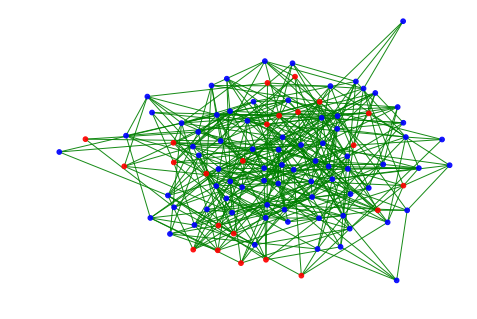

1.0
ACO Concurrent: 77


In [41]:
color_map = []
min_num = 100000000000
solutions = []
for ant in ants_list:
    if len(ant.history_vertices) < min_num:
        solutions = ant.history_vertices
        min_num = len(ant.history_vertices)

for node in G:
    if node in solutions:
        color_map.append('blue')
    else: 
        color_map.append('red')      

edge_colours = []
for (u,v) in G.edges():
    if u in solutions or v in solutions:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
networkx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))
ant_cost_concurrent = 0
for vertex in solutions:
    ant_cost_concurrent += vertex_weights[vertex]
print(f"ACO Concurrent: {ant_cost_concurrent}")

# ACO Proper

In [42]:
import time
num_ants = 30
alpha = 2
q_0 = 0.5
evaporation_rate = 0.01
adj_list=deepcopy(ADJACENCY_LIST)
adj_mat = deepcopy(ADJACENCY_MATRIX)
edges = deepcopy(EDGES)
vertex_weights = deepcopy(VERTEX_WEIGHTS)
iterations = 50


In [43]:
def run_ants_optimized(num_vertices, num_ants, weight_dict, alpha, q_0, evaporation_rate, adj_list, adj_mat, iterations): #  returns ((ant.number, path_length), iter)
    pheromone_dict = {i:0.1 for i in range(num_vertices)}
    iter = 0
    no_visit_vertices = no_edge_vertices(adj_mat)
    all_solutions = []
    #initialize ants 
    ants_list = [Ant(i) for i in range(num_ants)]
    
    #The fun begins
    while iter < iterations:
        print("iteration: ", iter)
        return_ants_list = []
        ant_edges = {i:deepcopy(edges) for i in range(num_ants)}
        
        for ant in ants_list:
            ant.history_vertices = []
        local_pheromone_dict = defaultdict(float)
        
        for ant_number in range(num_ants):
            print(f"Ant: {ant_number}")
            curr_ant = ants_list[ant_number]
            if curr_ant in return_ants_list:
                continue
            if not ant_edges[ant_number]:
                return_ants_list.append(curr_ant)
                all_solutions.append(curr_ant.history_vertices)
                continue
            
            while len(ant_edges[ant_number]) > 0:
                possible_vertices = find_possible_vertices(curr_ant, adj_list, no_visit_vertices)
                if len(possible_vertices) == 0: 
                    print(ant_edges[ant_number], curr_ant.history_vertices)
                    print(f"Ant: {ant_number} is out of vertices to go to")
                    continue

                else:
                    choice_vertex = select_choice_vertex(curr_ant, adj_list, pheromone_dict, weight_dict, alpha, q_0, possible_vertices)
                
                curr_ant.add_to_visited(choice_vertex)
                local_pheromone_dict[choice_vertex] += 1/weight_dict[choice_vertex]
                ant_edges[ant_number] = [edge for edge in ant_edges[ant_number] if choice_vertex not in edge]
            if not ant_edges[ant_number]:
                    print("wtf 2")
                    return_ants_list.append(curr_ant)
                    all_solutions.append(curr_ant.history_vertices)
                    continue
        
        for vertex in local_pheromone_dict:
            pheromone_dict[vertex] = (1-evaporation_rate)*pheromone_dict[vertex] + local_pheromone_dict[vertex]
        
        iter += 1
    
    return return_ants_list, all_solutions


In [44]:
ants_list, all_solutions = run_ants_optimized(n, num_ants, vertex_weights, alpha,q_0, evaporation_rate, adj_list, adj_mat, iterations)

iteration:  0
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
Ant: 10
wtf 2
Ant: 11
wtf 2
Ant: 12
wtf 2
Ant: 13
wtf 2
Ant: 14
wtf 2
Ant: 15
wtf 2
Ant: 16
wtf 2
Ant: 17
wtf 2
Ant: 18
wtf 2
Ant: 19
wtf 2
Ant: 20
wtf 2
Ant: 21
wtf 2
Ant: 22
wtf 2
Ant: 23
wtf 2
Ant: 24
wtf 2
Ant: 25
wtf 2
Ant: 26
wtf 2
Ant: 27
wtf 2
Ant: 28
wtf 2
Ant: 29
wtf 2
iteration:  1
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
Ant: 10
wtf 2
Ant: 11
wtf 2
Ant: 12
wtf 2
Ant: 13
wtf 2
Ant: 14
wtf 2
Ant: 15
wtf 2
Ant: 16
wtf 2
Ant: 17
wtf 2
Ant: 18
wtf 2
Ant: 19
wtf 2
Ant: 20
wtf 2
Ant: 21
wtf 2
Ant: 22
wtf 2
Ant: 23
wtf 2
Ant: 24
wtf 2
Ant: 25
wtf 2
Ant: 26
wtf 2
Ant: 27
wtf 2
Ant: 28
wtf 2
Ant: 29
wtf 2
iteration:  2
Ant: 0
wtf 2
Ant: 1
wtf 2
Ant: 2
wtf 2
Ant: 3
wtf 2
Ant: 4
wtf 2
Ant: 5
wtf 2
Ant: 6
wtf 2
Ant: 7
wtf 2
Ant: 8
wtf 2
Ant: 9
wtf 2
Ant: 10


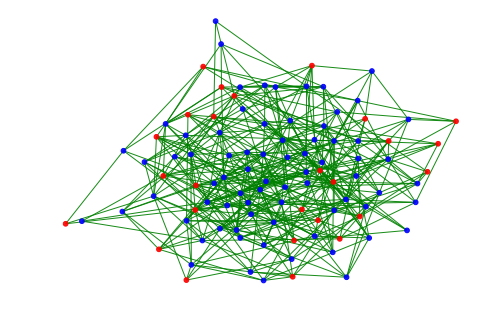

1.0
ACO Optimized: 74


In [45]:
color_map = []
min_num = 100000000000
solutions = []
for solution in all_solutions:
    if len(solution) < min_num:
        min_num = len(solution)
        solutions = solution
        
for node in G:
    if node in solutions:
        color_map.append('blue')
    else: 
        color_map.append('red')      

edge_colours = []
for (u,v) in G.edges():
    if u in solutions or v in solutions:
        edge_colours.append("green")
    else:
        edge_colours.append("red")
        
networkx.draw(G, node_color=color_map, edge_color=edge_colours, node_size=22, alpha=0.9)
plt.show()

edges_visited = 0
for col in edge_colours:
    if col == "green":
        edges_visited+=1
print(edges_visited/len(edge_colours))
ant_cost_optimized = 0
for vertex in solutions:
    ant_cost_optimized += vertex_weights[vertex]
print(f"ACO Optimized: {ant_cost_optimized}")

In [46]:
print(f"Greedy: {greedy_count}")
print(f"Unweighted Genetic Algorithm: {unweighted_genetic_cost}")
print(f"Weighted Genetic Algorithm: {genetic_cost}")
print(f"ACO Concurrent: {ant_cost_concurrent}")
print(f"ACO Concurrent: {ant_cost_optimized}")

Greedy: 87
Unweighted Genetic Algorithm: 80
Weighted Genetic Algorithm: 87
ACO Concurrent: 77
ACO Concurrent: 74


In [47]:
with open("Minimum_Vertex_Cover_Results.txt", 'a') as myfile:
    myfile.write(f"Greedy: {greedy_count}, Unweighted Genetic Algorithm: {unweighted_genetic_cost}, Weighted Genetic Algorithm: {genetic_cost}, ACO Concurrent: {ant_cost_concurrent}, ACO Optimized: {ant_cost_optimized}\n")